In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps

import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_extraction import text # to modify stop words

from collections import defaultdict, Counter

## Read csv and create additional columns:

In [2]:
# read csv making sure Answer column is a string because of "NULL" answers
df = pd.read_csv("nick-xword-big.csv",converters={'Answer' : str, 'Hint' : str})

df.sample(5)

,Year,Month,Day,Weekday,Direction,Line,Hint,Answer,Author,Editor,PuzTitle,PuzClue,NumRows,NumCols,NumWords,NumBlocks,MissingLetters
159677,2015,9,11,Friday,Down,18,Onetime big name in cassette tapes,MEMOREX,Peter A. Collins,Will Shortz,"New York Times, Friday, September 11, 2015","Who said ""If you tremble with indignation at e...",15,15,68,27,JKQ
686286,1997,11,11,Tuesday,Down,27,Questions,ASKS,Brendan Emmett Quigley,Will Shortz,"New York Times, Tuesday, November 11, 1997",Any point in a trapeze artist's routine,15,15,76,34,Y
204681,2014,3,18,Tuesday,Down,2,Eisenhower vis-�-vis West Point; informally,ALUM,David Kwong,Will Shortz,"New York Times, Tuesday, March 18, 2014","W.W. I novel ... hinted at by 17-, 24-, 52- an...",15,15,78,42,JQXZ
368393,2008,10,29,Wednesday,Down,36,Flag's position; at times,HALFMAST,Steven L. Zisser,Will Shortz,"New York Times, Wednesday, October 29, 2008","In romance poetry, a frequent rhyme for June",15,15,76,38,JX
119404,2017,1,8,Sunday,Across,24,Speed demon,RACER,Peter Broda and Erik Agard,Will Shortz,THE DOWNSIZING OF NATHANIEL AMES,"""Charlie Hustle is my name / I am banned from ...",21,21,138,71,FQ


In [3]:
# Create BlockDensity column
df['BlockDensity'] = (df['NumBlocks'] / (df['NumRows'] * df['NumCols']))*100

In [4]:
#Make a column for answer length
df['AnswerLength'] = df['Answer'].str.len()

In [5]:
# make a single date column (this should also serve a unique puzzle identifier)
df['Date'] = df['Year'].astype(str) +'-'+ df['Month'].astype(str) +'-'+ df['Day'].astype(str)
df['Date'] = pd.to_datetime(df['Date'])

### Basic stats:

In [6]:
# Puzzle count by author
df.groupby(['Author'])['PuzTitle'].nunique().sort_values(ascending=False).reset_index().head(10)

,Author,PuzTitle
0,Manny Nosowsky,224
1,Patrick Berry,214
2,Elizabeth C. Gorski,207
3,David J. Kahn,167
4,Rich Norris,159
5,Brendan Emmett Quigley,150
6,Joe DiPietro,126
7,Alan Arbesfeld,120
8,Randolph Ross,105
9,Peter A. Collins,99


In [7]:
#Average number of blocks by weekday
df.groupby(['Weekday'])['NumBlocks'].mean().sort_values(ascending=False).reset_index()

,Weekday,NumBlocks
0,Sunday,75.364446
1,Monday,37.537245
2,Wednesday,37.485311
3,Tuesday,37.417742
4,Thursday,37.013904
5,Friday,31.464006
6,Saturday,30.743494


In [8]:
# top ten longest answers
df.sort_values(by='AnswerLength',ascending=False).head(10)[['Weekday','Hint','Answer','AnswerLength']]

,Weekday,Hint,Answer,AnswerLength
763707,Sunday,Word chain #1 (12 wds.; coming full circle),HOUSEPARTYLINEDRIVEWAYSIDEKICKBACKHANDOVERNIGH...,52
560325,Sunday,Cry heard shortly before 16-Down,TENNINEEIGHTSEVENSIXFIVEFOURTHREETWOONEITSTWOO...,50
363929,Sunday,Greeting from 74-Down,HOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHO,42
143463,Thursday,-,CIRCULARREASONINGMAKESNOSENSEBECAUSE,36
473725,Sunday,Mock plea for civil language,STOPTHEPOUNDATPERCENTSTARANDCUSSING,35
193441,Thursday,Visual representation of this puzzle's theme,SPACESPACESPACESPACESPACESPACESPACE,35
163819,Thursday,Mouthful from a 1964 song,SUPERCALIFRAGILISTICEXPIALIDOCIOUS,34
460729,Thursday,Piano exercise for beginners,DOREMIFASOLLATIDOTILASOLFAMIREDO,32
481784,Sunday,Call for help,DOTDOTDOTDASHDASHDASHDOTDOTDOT,30
287031,Friday,Pro-Church of England position,ANTIDISESTABLISHMENTARIANISM,28


## block density

blocks = the black squares on the puzzle grid

In [9]:
# Get the average BlockDensity by day, and also all individual BlockDensity values for the plot later
block_data = df.groupby(['Weekday'])['BlockDensity'].agg([np.mean, np.std, list]).reset_index()
block_data

,Weekday,mean,std,list
0,Friday,13.969817,1.888206,"[14.222222222222221, 14.222222222222221, 14.22..."
1,Monday,16.666676,1.052465,"[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16...."
2,Saturday,13.645211,1.753924,"[12.88888888888889, 12.88888888888889, 12.8888..."
3,Sunday,16.796030,1.194783,"[17.233560090702948, 17.233560090702948, 17.23..."
4,Thursday,16.404469,1.443694,"[17.77777777777778, 17.77777777777778, 17.7777..."
5,Tuesday,16.600833,1.057248,"[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16...."
6,Wednesday,16.613964,1.178799,"[15.11111111111111, 15.11111111111111, 15.1111..."


In [10]:
# Sort by the mean
block_data.sort_values(by='std', ascending=False, inplace=True)

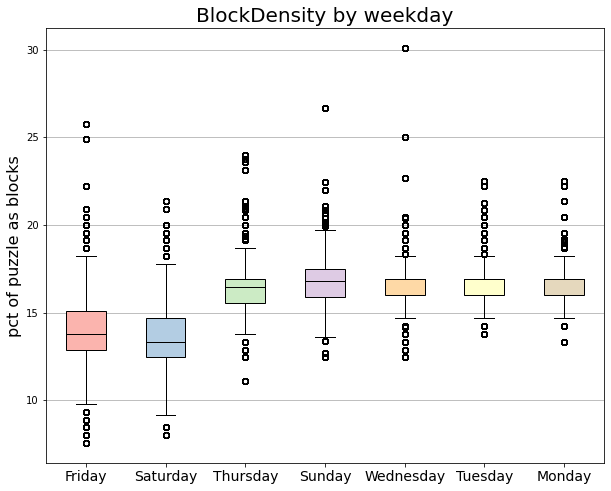

In [11]:
# plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
bplot = ax.boxplot(block_data['list'],patch_artist=True, medianprops=dict(color='black'))
ax.set_xticklabels(block_data['Weekday'].tolist(),fontsize=14)
ax.set_ylabel('pct of puzzle as blocks',fontsize=16)
ax.set_title('BlockDensity by weekday',fontsize=20)
ax.grid(True,axis='y')

cmap = cm.get_cmap('Pastel1')

for patch, color in zip(bplot['boxes'], cmap.colors):
    patch.set_facecolor(color)
#plt.savefig(fname="density")
plt.show()

## puzzle density over time

In [12]:
time_data = df.groupby(['Weekday','Year'])['BlockDensity'].mean().reset_index().copy()

time_data

,Weekday,Year,BlockDensity
0,Friday,1994,16.573682
1,Friday,1995,15.200780
2,Friday,1996,14.459082
3,Friday,1997,14.596993
4,Friday,1998,14.504471
...,...,...,...
184,Wednesday,2016,16.606938
185,Wednesday,2017,16.689204
186,Wednesday,2018,16.889263
187,Wednesday,2019,16.931687


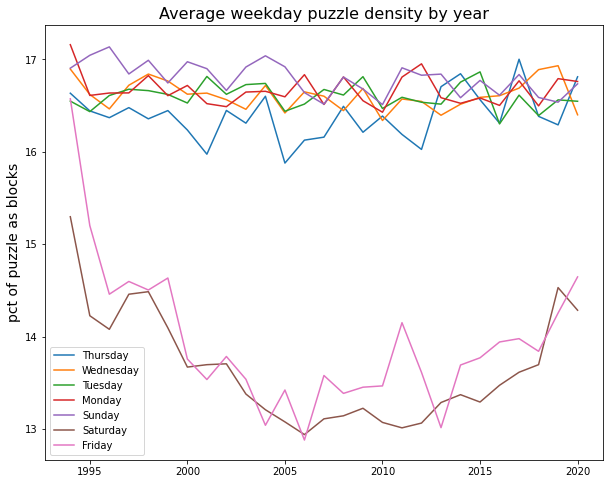

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

for day in df.Weekday.unique().tolist():
    ax.plot(time_data['Year'].loc[time_data['Weekday'] == day],time_data['BlockDensity'].loc[time_data['Weekday'] == day],label=day)


ax.set_ylabel('pct of puzzle as blocks',fontsize=14)
ax.set_title('Average weekday puzzle density by year',fontsize=16)
ax.legend()

plt.show()

## average answer length

In [14]:
len_data = df.groupby('Weekday')['AnswerLength'].agg([np.mean, list]).reset_index().copy()
len_data.sort_values(by='mean', ascending=True, inplace=True)
len_data

,Weekday,mean,list
1,Monday,4.876887,"[4, 5, 4, 4, 5, 4, 4, 5, 4, 6, 8, 5, 5, 3, 3, ..."
5,Tuesday,4.896390,"[4, 4, 5, 4, 4, 5, 15, 3, 6, 4, 3, 7, 12, 4, 3..."
6,Wednesday,4.935521,"[4, 4, 5, 9, 5, 9, 5, 3, 11, 3, 3, 6, 4, 4, 4,..."
4,Thursday,5.109273,"[3, 4, 5, 3, 4, 6, 3, 4, 6, 10, 6, 8, 4, 6, 7,..."
3,Sunday,5.309589,"[5, 6, 4, 3, 5, 6, 4, 3, 12, 8, 4, 6, 4, 4, 5,..."
0,Friday,5.579388,"[5, 5, 3, 5, 5, 3, 5, 5, 3, 10, 4, 6, 7, 3, 4,..."
2,Saturday,5.652210,"[3, 4, 6, 8, 6, 8, 6, 10, 4, 4, 4, 4, 6, 3, 4,..."


In [15]:
# inspect short answers
df.loc[df['Answer'].str.len() < 2]

,Year,Month,Day,Weekday,Direction,Line,Hint,Answer,Author,Editor,PuzTitle,PuzClue,NumRows,NumCols,NumWords,NumBlocks,MissingLetters,BlockDensity,AnswerLength,Date
5830,2020,10,22,Thursday,Across,21,What's theorized to have preceded the Big Bang,,Sid Sivakumar,Will Shortz,"New York Times, Thursday, October 22, 2020",Keeps going despite fatigue ... or a hint to t...,15,15,78,40,NaN,17.777778,0,2020-10-22
5837,2020,10,22,Thursday,Across,36,What polar opposites have in common,,Sid Sivakumar,Will Shortz,"New York Times, Thursday, October 22, 2020",Keeps going despite fatigue ... or a hint to t...,15,15,78,40,NaN,17.777778,0,2020-10-22
5847,2020,10,22,Thursday,Across,50,What's uttered by a mime,,Sid Sivakumar,Will Shortz,"New York Times, Thursday, October 22, 2020",Keeps going despite fatigue ... or a hint to t...,15,15,78,40,NaN,17.777778,0,2020-10-22
210363,2014,1,9,Thursday,Across,65,___-square,T,Caleb Emmons,Will Shortz,"New York Times, Thursday, January 9, 2014","Lucy ___, title character in Sir Walter Scott'...",15,15,76,40,KWX,17.777778,1,2014-01-09
216212,2013,10,31,Thursday,Across,65,64-Across; in 23-Down,,David Kwong,Will Shortz,"New York Times, Thursday, October 31, 2013",Nickname for a 2012 presidential candidate,15,15,78,36,NaN,16.000000,0,2013-10-31


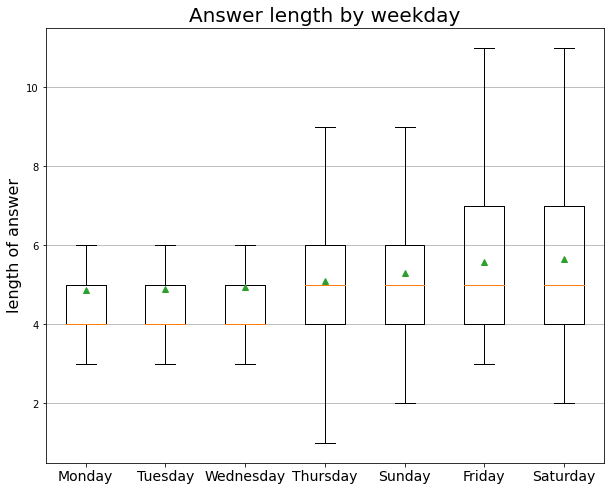

In [16]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(10, 8)

ax1.boxplot(len_data['list'], showfliers=False, showmeans=True)
ax1.set_xticklabels(len_data['Weekday'].tolist(),fontsize=14)
ax1.set_ylabel('length of answer',fontsize=16)
ax1.set_title('Answer length by weekday',fontsize=20)
ax1.grid(True,axis='y')

plt.show()

## scikit learn tfidf

### tfidf for answers by day of week

In [17]:
# concatenate all answers together in a single cell
# only year 2000 to keep things managable while testing
df_ans = df.loc[df['Year'] == 2000].groupby(['Weekday','Date'])['Answer'].apply(lambda x: " ".join(x)).reset_index().copy()

In [18]:
ans_vectorizer = TfidfVectorizer() 

In [19]:
ans_tfidf = ans_vectorizer.fit_transform(df_ans['Answer'])

In [20]:
ans_tfidf.toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [21]:
ans_tfidf.shape

(364, 16797)

In [22]:
# reduce tfidf vector space to 2 dimensions with PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(ans_tfidf.todense())

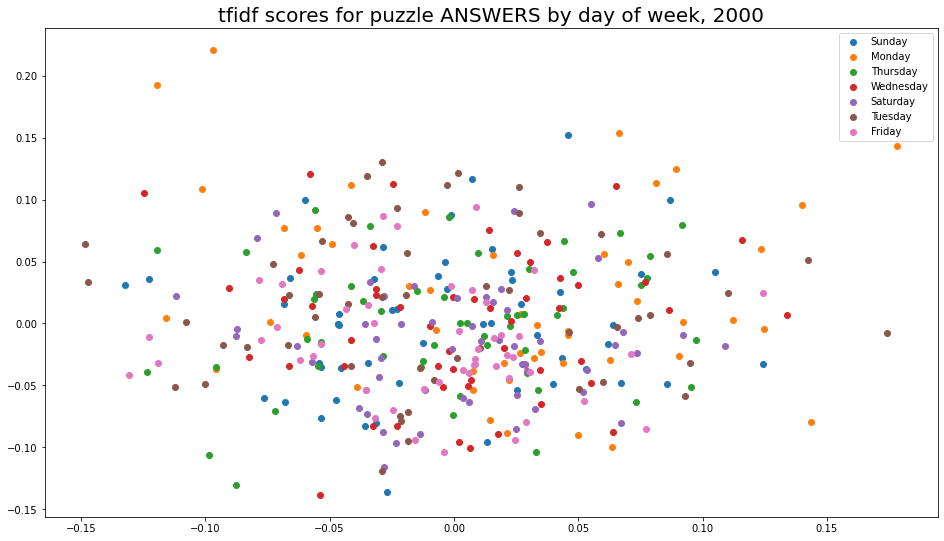

In [23]:
# transpose the reduced space for plotting
t = reduced.transpose()

# list of weekday labeles, with indices preserved
day_labels = df_ans['Weekday'].tolist()
#day_idx = {}

fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("tfidf scores for puzzle ANSWERS by day of week, 2000",fontsize=20)
for day in list(set(day_labels)):
    day_indices = [i for i, x in enumerate(day_labels) if x == day]
    ax.scatter(t[0][day_indices], t[1][day_indices],label=day)

plt.legend()
plt.show()

### tfidf for hints by day of week

In [24]:
df_hints = df.loc[df['Year'] == 2000].groupby(['Weekday','Date'])['Hint'].apply(lambda x: " ".join(x)).reset_index().copy()

In [25]:

hint_vectorizer = TfidfVectorizer(stop_words='english') 
ans_tfidf = hint_vectorizer.fit_transform(df_hints['Hint'])
pca = PCA(n_components=2)

reduced = pca.fit_transform(ans_tfidf.todense())




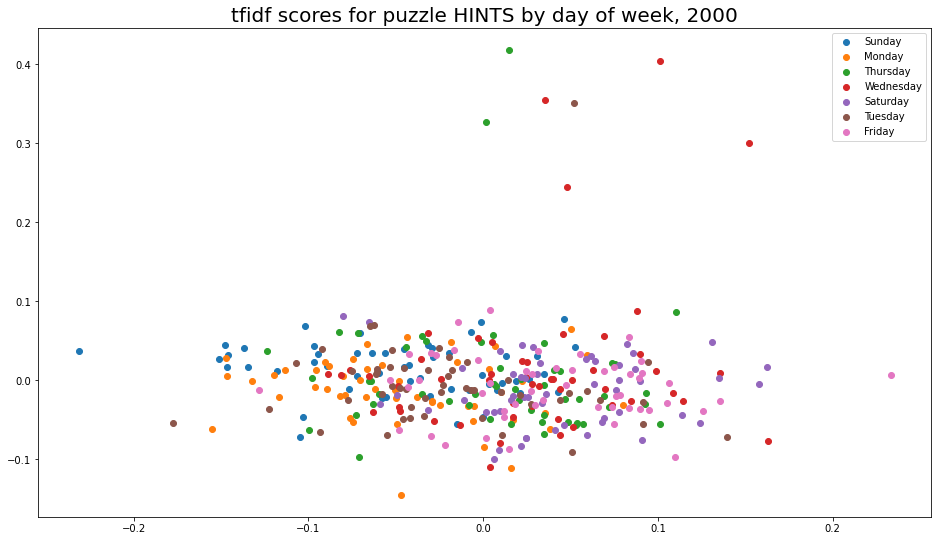

In [26]:
t = reduced.transpose()
day_labels = df_ans['Weekday'].tolist()

fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("tfidf scores for puzzle HINTS by day of week, 2000",fontsize=20)
for day in list(set(day_labels)):
    day_indices = [i for i, x in enumerate(day_labels) if x == day]
    ax.scatter(t[0][day_indices], t[1][day_indices],label=day)

plt.legend()
plt.show()

### tfidf for hints by year

In [27]:
df_years = df.loc[df['Weekday'] == 'Sunday'].groupby(['Year','Date'])['Hint'].apply(lambda x: " ".join(x)).reset_index().copy()

In [28]:
# add 'fill in the blank' string as stop word (but we could also keep this!)
nyt_stop = ['___']

stop_words = text.ENGLISH_STOP_WORDS.union(nyt_stop)

year_vectorizer = TfidfVectorizer(use_idf=True, stop_words=stop_words, smooth_idf=True) 

yr_tfidf = year_vectorizer.fit_transform(df_years['Hint'])
pca = PCA(n_components=2)

reduced = pca.fit_transform(yr_tfidf.todense())
t = reduced.transpose()
labels = df_years['Year'].tolist()


In [29]:
t[1][1000]

0.0017334780534626884

In [30]:
df_years['Date'].iloc[1000]

Timestamp('2013-05-19 00:00:00')

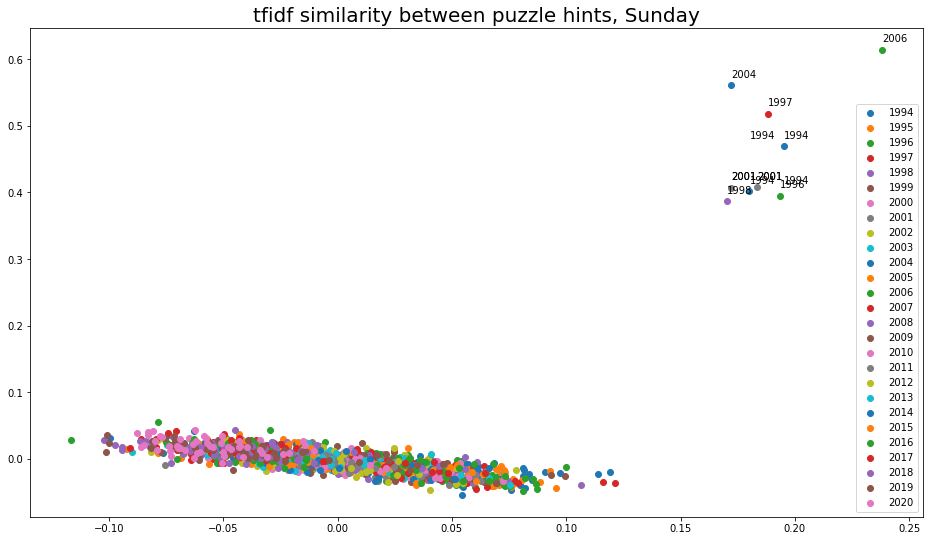

Potentially strange puzzles: 
https://www.xwordinfo.com/Crossword?date=2/20/1994
https://www.xwordinfo.com/Crossword?date=4/10/1994
https://www.xwordinfo.com/Crossword?date=2/20/1994
https://www.xwordinfo.com/Crossword?date=4/10/1994
https://www.xwordinfo.com/Crossword?date=1/28/1996
https://www.xwordinfo.com/Crossword?date=8/3/1997
https://www.xwordinfo.com/Crossword?date=7/12/1998
https://www.xwordinfo.com/Crossword?date=3/11/2001
https://www.xwordinfo.com/Crossword?date=7/15/2001
https://www.xwordinfo.com/Crossword?date=3/11/2001
https://www.xwordinfo.com/Crossword?date=7/15/2001
https://www.xwordinfo.com/Crossword?date=8/15/2004
https://www.xwordinfo.com/Crossword?date=9/24/2006


In [31]:
potentially_strange_puzzles = []
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("tfidf similarity between puzzle hints, Sunday",fontsize=20)
for yr in list(set(labels)):
    year_index = [i for i, x in enumerate(labels) if x == yr]
    x, y = t[0][year_index], t[1][year_index]
    ax.scatter(x, y, label=yr)
    # this loop only annotates those outlier points, eyeballing the coordinates
    for i in x:
        if i > 0.15:
            for j, yr_idx in zip(y,year_index):
                if j > 0.2:
                    ax.annotate(str(yr),(i,j),xytext=(0,8),textcoords='offset points')
                    potentially_strange_puzzles.append(df_years['Date'].iloc[yr_idx])

plt.legend()
plt.show()
print(f"Potentially strange puzzles: ")
for puzz in potentially_strange_puzzles:
      print(f"https://www.xwordinfo.com/Crossword?date={puzz.month}/{puzz.day}/{puzz.year}")

## finding answers unique to each puzzle

In [32]:
df_uniques = df.groupby(['Date'])['Answer'].apply(list).reset_index().copy()
df_uniques.sample(5)

,Date,Answer
8361,2017-03-04,"[SGTS, TREVI, STUB, PIAF, HERON, ARTI, ANYONEL..."
1070,1996-12-30,"[LATHE, AROMA, BAS, ARIEL, DORAL, RNA, DROPTHE..."
7929,2015-12-27,"[SIPON, ABASES, TEAMO, UNLOAD, NATASHA, AVIANS..."
7870,2015-10-29,"[IHOP, EASE, DRIPS, POUR, SLAB, RADON, SOCIALL..."
589,1995-08-27,"[MAP, BOBS, GROWUP, ASSTS, AVEMARIA, DENISE, P..."


In [33]:
ans_dict = defaultdict(list)

# build a dictionary with answers for keys and puzzles for values
for index, row in df_uniques.iterrows():
    for ans in row['Answer']:
        ans_dict[ans].append(index)

# find all keys mapped to only one puzzle
unique_ans = [hint for hint, pz in ans_dict.items() if len(pz) == 1]

# take the intersection of a puzzle's answers with the unique answer set (applied below)
def get_unique_clues(row):
    return list(set(row).intersection(set(unique_ans)))


In [34]:
# Column for a list of unique answers
df_uniques['UniqueClues'] = df_uniques['Answer'].apply(get_unique_clues)

In [35]:
# Column for the number of unique answers per puzzle
df_uniques['NumUniques'] = df_uniques['UniqueClues'].apply(len)

In [36]:
# Recreate the weekday column (oops)
df_uniques['Weekday'] = df['Date'].apply(lambda x: x.day_name())

In [37]:
# Inspect
df_uniques.sample(5)

,Date,Answer,UniqueClues,NumUniques,Weekday
7832,2015-09-21,"[METS, HTTP, SMASH, UNIT, OWIE, KAPPA, SORESPO...","[SITSSTILL, STOPSSHORT, STEEPSLOPE, SELLSTOCKS]",4,Sunday
6246,2011-05-18,"[POD, SERPICO, AGE, ABO, OVERMAN, LOT, GET, WI...","[FIXON, OPATRIA, GRIFFITH, OVERMAN, WILIEST, J...",6,Sunday
2651,2001-05-04,"[ONESPOT, CITRIC, RESPIGHI, ONEIDA, EXTENDED, ...","[SHEPHERDED, EAVESDROPS, RESPIGHI, STOCKERS, C...",6,Sunday
1634,1998-07-17,"[KAMIKAZE, SCAMS, EXAMINER, SHAPES, NICOTINE, ...","[HANDMIXER, TENANTFARMER, ERRANTRY, AMPUTATE]",4,Saturday
5407,2009-01-29,"[IZE, OUTWIT, MACS, OWN, IPHONE, YVES, LEGALPR...","[UNITOFPRESSURE, LEGALPROFESSION, UPPERS, MUSI...",5,Tuesday


In [38]:
unique_data = df_uniques.groupby('Weekday')['NumUniques'].agg([np.mean, list]).reset_index().copy()
unique_data.sort_values(by='mean', inplace=True)
unique_data

,Weekday,mean,list
4,Thursday,5.588976,"[2, 16, 2, 3, 2, 7, 5, 10, 14, 4, 1, 0, 2, 3, ..."
0,Friday,5.624579,"[8, 3, 8, 19, 5, 2, 5, 4, 7, 3, 9, 2, 5, 6, 5,..."
2,Saturday,5.681159,"[6, 12, 3, 4, 5, 2, 8, 0, 12, 1, 4, 4, 7, 8, 3..."
6,Wednesday,5.706843,"[5, 11, 2, 3, 8, 4, 9, 7, 8, 0, 5, 8, 5, 5, 6,..."
1,Monday,5.747320,"[6, 5, 13, 2, 1, 9, 6, 4, 5, 10, 3, 3, 3, 2, 6..."
3,Sunday,5.758311,"[11, 11, 2, 4, 2, 6, 8, 6, 11, 4, 1, 5, 6, 9, ..."
5,Tuesday,5.814985,"[9, 8, 9, 6, 9, 3, 2, 4, 2, 7, 4, 14, 4, 8, 5,..."


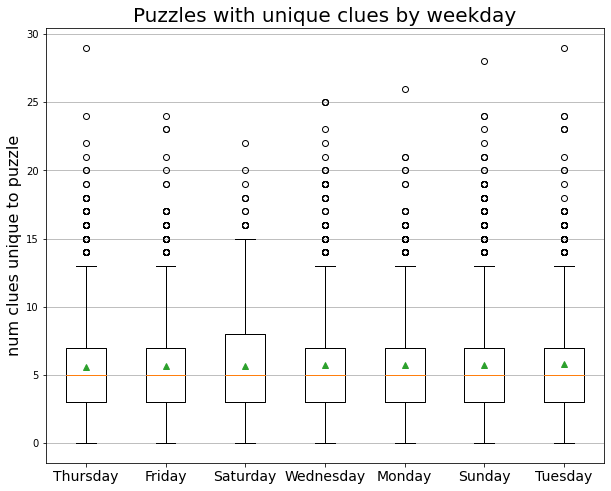

In [39]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(10, 8)

ax1.boxplot(unique_data['list'], showfliers=True, showmeans=True)
ax1.set_xticklabels(unique_data['Weekday'].tolist(),fontsize=14)
ax1.set_ylabel('num clues unique to puzzle',fontsize=16)
ax1.set_title('Puzzles with unique clues by weekday',fontsize=20)
ax1.grid(True,axis='y')

plt.show()